In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.cm as cm
import cubehelix
from scipy import stats
import matplotlib as mpl
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['axes.color_cycle'] = ['#CC0066', '#666677', '#ff8833']

In [2]:

from ase import Atoms
from ase.units import Bohr
from gpaw.jellium import JelliumSurfacePoissonSolver
from gpaw import GPAW, Mixer

### Run a surface calculation

/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy-1.10.0.dev0+564a5a2-py2.7-macosx-10.10-x86_64.egg/numpy/core/fromnumeric.py:2596: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


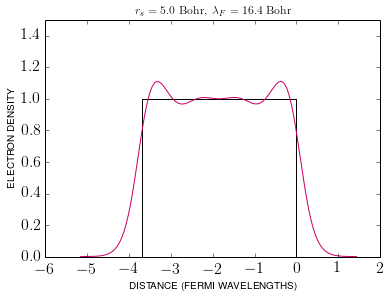

In [3]:
mpl.rc('text', usetex=True)
rs = 5.0 * Bohr
calc = GPAW('surface.gpw', txt=None)
density = calc.get_pseudo_density()[0, 0]
h = 0.2
a = 8 * h
v = 8 * a
L = 20 * a
z = np.linspace(0, v + L + v, len(density), endpoint=False)
# Position of surface is between two grid points:
z0 = (v + L - h / 2)
n = 1 / (4 * np.pi / 3 * rs**3)  # electron density
kF = (3 * np.pi**2 * n)**(1.0 / 3)
lambdaF = 2 * np.pi / kF  # Fermi wavelength
plt.figure(figsize=(6, 6 / 2**0.5))
plt.plot([-L / lambdaF, -L / lambdaF, 0, 0], [0, 1, 1, 0], 'k')
plt.plot((z - z0) / lambdaF, density / n)
plt.plot((z - z0) / lambdaF, density-1 / n)
#plt.xlim(xmin=-1.2, xmax=1)
plt.ylim(ymin=0,ymax=1.5)
plt.title(r'$r_s=%.1f\ \mathrm{Bohr},\ \lambda_F=%.1f\ \mathrm{Bohr}$' %
          (rs / Bohr, lambdaF / Bohr))
plt.xlabel('DISTANCE (FERMI WAVELENGTHS)')
plt.ylabel('ELECTRON DENSITY')
plt.show()
#plt.savefig('fig2.png')

In [4]:
background = []
step_size = (z[1]-z[0])/lambdaF
print step_size
for i, point in enumerate(density):
    if (z[i] - z0)/lambdaF >= -L / lambdaF and (z[i] - z0)/lambdaF <= 0.:
        background.append(1.)
    else:
        background.append(0.)

0.0519484108718


In [5]:
dens = []
for i, point in enumerate(density):
    dens.append(point/n)

In [6]:
diff = []
for i, point in enumerate(dens):
    diff.append(background[i]-point/n)

In [7]:
len(density)

128

### Create a cubic spline of the density
The density and the bancgorund weere not quite commensurate for a symmetric difference

In [8]:
from scipy.interpolate import interp1d
f2 = interp1d((z-z0)/lambdaF,density/n , kind='cubic')
total_len = max((z-z0)/lambdaF) - min((z-z0)/lambdaF)

In [9]:
new_density = []
abscissa = np.arange(min((z-z0)/lambdaF),max((z-z0)/lambdaF),total_len/4000)
for i in range(len(abscissa)):
    new_density.append(f2(abscissa[i]))

In [10]:
new_background = []
width_slab = total_len/2
for i, value in enumerate(new_density):
    if i >= 889 and i <= 3129 :
        new_background.append(1.)
    else:
        new_background.append(0.)
        

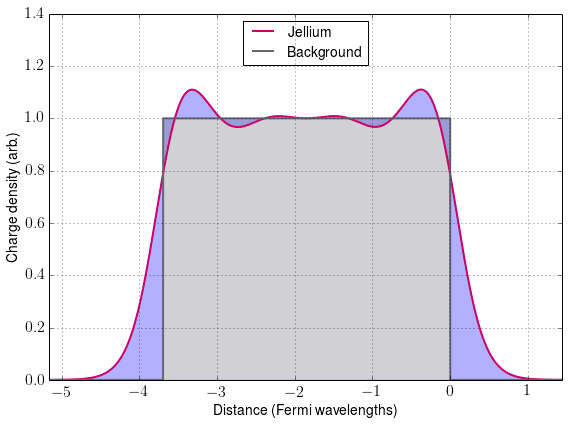

In [58]:
fig = plt.figure(figsize=(8,6))

plt.plot(abscissa,new_density,linewidth=2.0, label='Jellium')
plt.plot(abscissa,new_background,linewidth=2.0,label='Background')
plt.fill_between(abscissa,new_density,new_background,alpha=0.3,color='b')
plt.fill_between(abscissa,new_background,0,alpha=.3,color='#666677')
plt.grid(True)
plt.xlim(min(abscissa),max(abscissa))
plt.ylim(0,1.4)
plt.legend(loc='upper center', fontsize=14)
plt.xlabel('Distance (Fermi wavelengths)', fontsize=14)
plt.ylabel('Charge density (arb.)', fontsize=14)
new_diff = []
for i, point in enumerate(new_density):
    new_diff.append(new_background[i] - point)

plt.tight_layout()
plt.savefig('Density.png')

In [33]:
np.savetxt('dens.dat',new_density)
np.savetxt('abscissa.dat',abscissa)

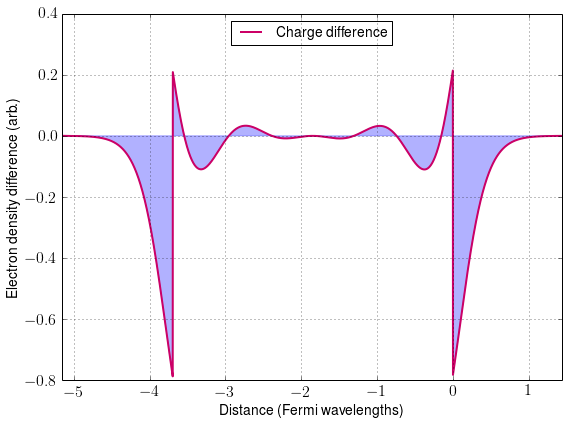

In [59]:
fig = plt.figure(figsize=(8,6))

plt.plot(abscissa,new_diff,label='Charge difference',linewidth=2.)
plt.grid(True)
plt.xlim(min(abscissa),max(abscissa))
plt.fill_between(abscissa,new_diff,0,alpha=0.3,color='b')
#plt.ylim(0,0.3)
plt.legend(loc='upper center', fontsize=14)
plt.xlabel('Distance (Fermi wavelengths)', fontsize=14)
plt.ylabel('Electron density difference (arb.)', fontsize=14)
plt.tight_layout()
plt.savefig('Difference.png')

In [35]:
distances = []; charge = []
for i, d in enumerate(new_density):
    distances.append(abscissa[i])
    charge.append(new_diff[i]/10000)

### John's Poisson solver

In [36]:
chargedifference = zip(abscissa,charge)
np.savetxt('chargedifference.dat',chargedifference)

In [37]:
potential = []
for line in open('potential.dat'):
    a, b = [float(f) for f in line.split()[0:2]]
    potential.append(b)

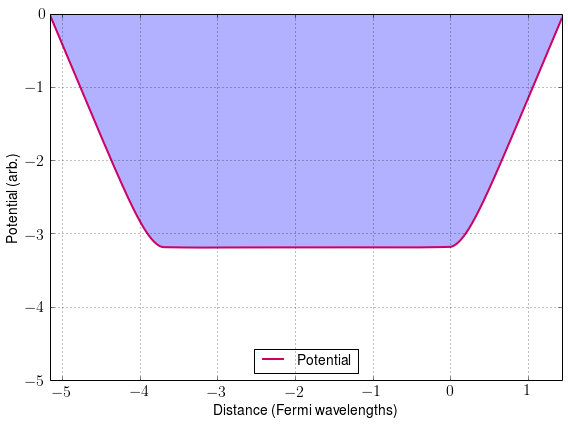

In [60]:
fig = plt.figure(figsize=(8,6))
plt.plot(abscissa,potential,label='Potential',linewidth=2.)
plt.grid(True)
plt.xlim(min(abscissa),max(abscissa))
plt.ylim(-5,0)
plt.fill_between(abscissa,potential,0,alpha=0.3,color='b')
plt.legend(loc='lower center', fontsize=14)
plt.xlabel('Distance (Fermi wavelengths)', fontsize=14)
plt.ylabel('Potential (arb.)', fontsize=14)
plt.tight_layout()
plt.savefig('Potential.png')

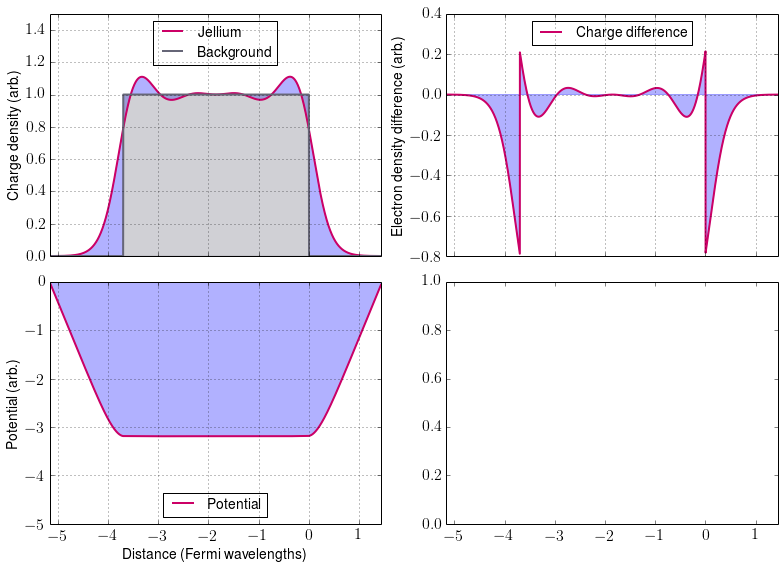

In [66]:
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2, sharex=True)
f.set_size_inches(11,8)
#  Upper 
axarr[0,0].plot(abscissa,new_density,linewidth=2.0, label='Jellium')
axarr[0,0].plot(abscissa,new_background,linewidth=2.0,label='Background')
axarr[0,0].fill_between(abscissa,new_density,new_background,alpha=0.3,color='b')
axarr[0,0].fill_between(abscissa,new_background,0,alpha=.3,color='#666677')
axarr[0,0].grid(True)
axarr[0,0].set_xlim(min(abscissa),max(abscissa))
axarr[0,0].set_ylim(0,1.5)
axarr[0,0].legend(loc='upper center', fontsize=14)
axarr[0,0].set_ylabel('Charge density (arb.)', fontsize=14)

#Middle
axarr[0,1].plot(abscissa,new_diff,label='Charge difference',linewidth=2.)
axarr[0,1].grid(True)
axarr[0,1].set_xlim(min(abscissa),max(abscissa))
axarr[0,1].fill_between(abscissa,new_diff,0,alpha=0.3,color='b')
axarr[0,1].legend(loc='upper center', fontsize=14)
#plt.xlabel('Distance (Fermi wavelengths)', fontsize=14)
axarr[0,1].set_ylabel('Electron density difference (arb.)', fontsize=14)

# Lower
axarr[1,0].plot(abscissa,potential,label='Potential',linewidth=2.)
axarr[1,0].grid(True)
axarr[1,0].set_xlim(min(abscissa),max(abscissa))
axarr[1,0].set_ylim(-5,0)
axarr[1,0].fill_between(abscissa,potential,0,alpha=0.3,color='b')
axarr[1,0].legend(loc='lower center', fontsize=14)
axarr[1,0].set_xlabel('Distance (Fermi wavelengths)', fontsize=14)
axarr[1,0].set_ylabel('Potential (arb.)', fontsize=14)

f.tight_layout()
f.savefig('JelliumExperiment.pdf')
plt.show()

In [70]:
1.59264*2.45572*0.81370

3.18244408788096